In [ ]:
import os  # arquivos
import gensim # modelos 
from gensim.models import Word2Vec, KeyedVectors # treinar o modelo
from gensim.test.utils import get_tmpfile # ler modelo
from zipfile import ZipFile # ler arquivos zip

import warnings  #avisos
import pandas as pd  # para manipular a base de dados
import torch  #tensores
import numpy as np #calculos
import re #manipular strings


import nltk
from nltk.corpus import stopwords  
from nltk.tokenize import sent_tokenize, word_tokenize # frases e palavras do texto
from nltk import flatten  #juntar listas
from nltk import pos_tag

from google.colab import files
import matplotlib.pyplot as plt 
% matplotlib inline

In [ ]:
# Conectando com o google drive
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/TCC'
%cd '/content/drive/My Drive/TCC'

Mounted at /content/drive
 antes_box.png		     Modelo4.ipynb
 antes_freq.png		     palavras.xlsx
 antes.png		     Parte1TCC.ipynb
 antes_Wc.png		     Solucao_TCC.ipynb
'Compartilhar comprovante'   TCC_Modelo.ipynb
 depois_freq.png	     Teste1.xlsx
 depois.png		     Teste2_acordo-com-estados-unidos.xlsx
 depois_Wc.png		     Teste3_acordo-com-estados-unidos.xlsx
 Discursos_14052021.xlsx     Teste.xlsx
 Discursos.xlsx		     texto2.xlsx
 dps_box.png		     texto_limpo.xlsx
 estudo_variaveis1.xlsx      TFIDF.ipynb
 estudo_variaveis2.xlsx      w2v.vectors.kv
 estudo_variaveis.xlsx	     w2v.vectors.kv.vectors.npy
 Modelo2TCC.ipynb	     w2v.vectors.zip
 Modelo3TCC.ipynb
/content/drive/My Drive/TCC


In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese') # lista de stopwords fornecida pela biblioteca nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Entendimento do problema 

Identificar o grau de relevância de cada discurso do presidente em relação ao tema de interesse da pesquisa. Portanto, deve-se modelar um sistema de Recuperação de Informação dos discursos do presidente, que retorne discursos relevantes sobre o tópico de interesse do usuário

## Compreensão dos dados

Os dados foram extraídos do site do Governo Federal, por intermedio do software RStudio. \

A tabela coletada no RStudio fornece as seguintes colunas:

- **Ind**: índice para cada discurso;
- **DataHora**: Data e hora dos discursos;
- **Titulo**: título do discurso proferido pelo presidente;
- **Texto**: transcrição do discursos proferidos pelo presidente.

In [ ]:
df = pd.read_excel("Discursos.xlsx")   #Lendo base de discursos
df.rename(columns={'Unnamed: 0': 'Ind'}, inplace = True)
df.head()

,Ind,DataHora,Titulo,Texto
0,1,15/10/2021 14h42,"Discurso do Presidente da República, Jair Bols...",(...). Eu amo Israel.\nAgradeço a Deus pela mi...
1,2,13/10/2021 17h05,"Discurso do Presidente da República, Jair Bols...","Miracatu/SP, 13 de outubro de 2021\n\nBom dia ..."
2,3,09/10/2021 16h48,"Discurso do Presidente da República, Jair Bols...",É uma satisfação mais uma vez voltar a esse am...
3,4,07/10/2021 22h14,"Discurso do Presidente da República, Jair Bols...",Boa tarde a todos a gente se pergunta como é q...
4,5,06/10/2021 19h51,"Discurso do Presidente da República, Jair Bols...","Boa tarde a todos, tô me sentindo 40 anos mais..."


## Preparação dos dados
- Análise dos dados
- Limpeza dos dados
- Análise dos dados limpos
- Trasnformação das palavras em vetores (Embedding e TF-IDF)


Começaremos a análise com estatísticas de dados de texto muito simples, como comprimento de texto e frequência de palavras. Depois disso, investigaremos características de texto mais sofisticadas usando palavras desconhecidas e engenharia de recursos. Por fim, usaremos um método de modelagem de tópicos baseado em aprendizado de máquina para criar recursos semânticos do texto e avaliar o texto no contexto da análise de série temporal.

### Comprimento do texto
O comprimento das amostras no conjunto de dados é muito importante, pois pode afetar a forma como você representa seu texto como recursos para os modelos de ML. Por exemplo, TF-IDF é geralmente muito esparso para textos curtos e Word2Vec comum geralmente é muito barulhento para textos longos.

O comprimento também pode afetar o algoritmo que você usa. Por exemplo, as redes LSTM são muito melhores do que as redes RNN convencionais em textos longos.

count     456.000000
mean      928.971491
std       735.089742
min        60.000000
25%       456.750000
50%       741.500000
75%      1121.500000
max      5353.000000
Name: Texto, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

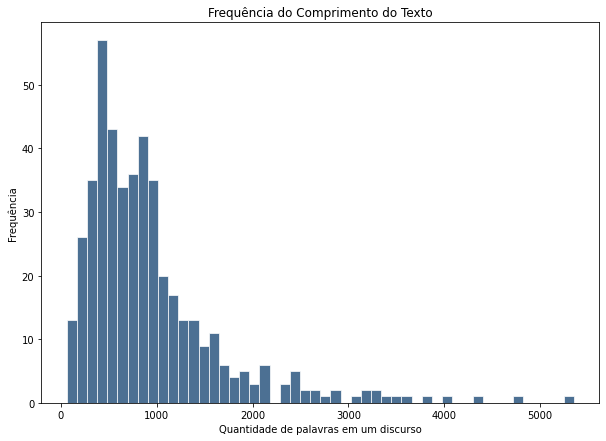

In [ ]:
lens = df.Texto.str.split().apply(lambda x: len(x)) # Quantidade de palavras no texto
import matplotlib.pyplot as plt
print(lens.describe()) 
fig = plt.figure(figsize =(10, 7))
plt.title('Frequência do Comprimento do Texto')
plt.xlabel('Quantidade de palavras em um discurso')
plt.ylabel('Frequência')
plt.hist(lens, 50, color='#003366', alpha=0.7,edgecolor='white')
plt.savefig("antes_freq.png")
files.download("antes_freq.png")
plt.show()

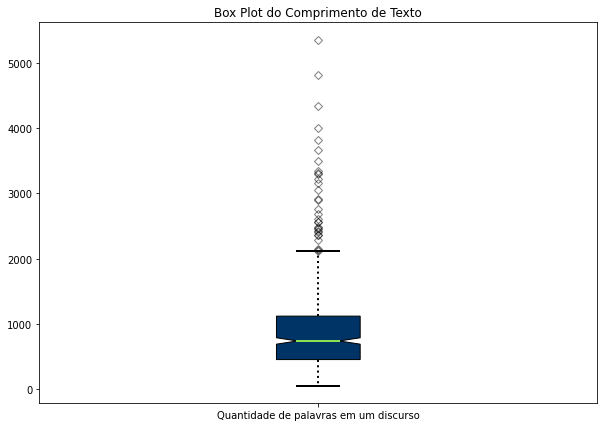

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot(lens, patch_artist =True,
                notch ='True', vert = 1)
bp['boxes'][0].set_facecolor('#003366')
bp['whiskers'][0].set(linewidth = 2,linestyle =":")
bp['whiskers'][1].set(linewidth = 2,linestyle =":")
bp['caps'][0].set(linewidth = 2)
bp['caps'][1].set(linewidth = 2)
bp['medians'][0].set(color ='#89E150',linewidth = 2)
bp['fliers'][0].set(marker ='D',color ='#A4FF6A',alpha = 0.5)
ax.set_xticklabels(['Quantidade de palavras em um discurso'])
plt.title("Box Plot do Comprimento de Texto")
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.show(bp)
plt.savefig("antes_box.png")
files.download("antes_box.png")

- Falar sobre a quantidade de palavras

In [ ]:
# Frequencia do termo 
from sklearn.feature_extraction.text import CountVectorizer
co = CountVectorizer()
counts = co.fit_transform(df.Texto)
palavras1 = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False)
palavras1 = palavras1.reset_index().rename(columns = {'index':'Nome',0:'Qtd'})
palavras1.head(50)

,Nome,Qtd
0,que,14852
1,de,13669
2,do,7063
3,para,6156
4,não,6029
5,um,5089
6,da,4660
7,eu,4479
8,em,4372
9,com,4331


In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd

data = dict(zip(palavras1['Nome'].tolist(), palavras1['Qtd'].tolist()))
wc = WordCloud(background_color="white", max_words=2000,
               max_font_size=256,
               random_state=42, width=1600, height=800)
wc.generate_from_frequencies(data)

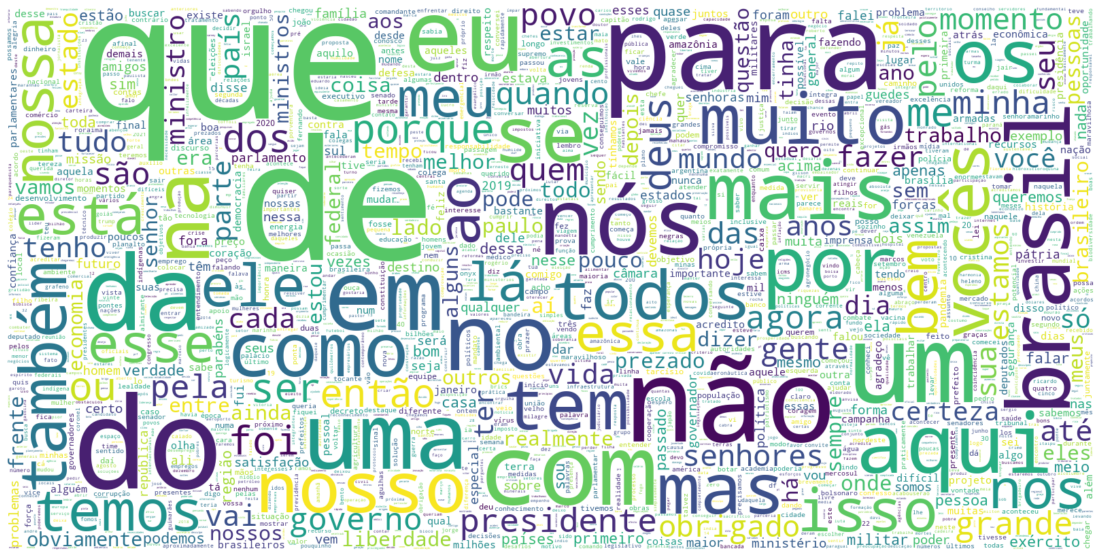

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.savefig("antes_Wc.png")
plt.axis('off')
plt.show()
from google.colab import files

files.download("antes_Wc.png") 

### Frequências de termo
Nesta etapa, encontro as palavras mais frequentes nos dados, extraindo informações sobre seu conteúdo e tópicos.

Ao fazer sua análise, lembre-se de adicionar palavras irrelevantes específicas do domínio, não apenas as palavras irrelevantes conhecidas em português. Eu removo as stopword desta análise em particular porque elas aparecem com frequência, mas não são muito informativas.

In [ ]:
# Colocar aonde for usar 
# Copiar o parágrafo de stopwords do TCC!!!!
df_stop = pd.read_excel("estudo_variaveis2.xlsx")   #Lista de stopwords personalizada dos 
palavras = list(set(df_stop['Lista'].to_list()))
stopwords.extend(palavras) # adicionando lista de palavras as stopwords

In [ ]:
def clean_text(text): 
  text = text.strip() #tira os espaços em branco duplos, do início e do final
  text = text.lower() #colocar em minusculo
  text = re.sub(r"[^a-zA-ZáàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ]", " ", text) #deixa somente palavras no texto
  lista = word_tokenize(text) #separa o texto em palavras
  lista = [palavra for palavra in lista if palavra not in stopwords] #tira as stopwords
  lista = [token for token, pos in pos_tag(lista) if lambda pos: pos[:2] == 'NN'] # deixa somente substantivos
  lista = [palavra for palavra in lista if len(palavra) >= 3] # deixa palavras com 3 ou mais letras
  #return lista
  return  ' '.join(lista)
df['Texto_Limpo'] = df.apply(lambda x: clean_text(x['Texto']),axis=1)

In [ ]:
# Frequencia do termo 
from sklearn.feature_extraction.text import CountVectorizer
co = CountVectorizer()
counts = co.fit_transform(df.Texto_Limpo)
palavras = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False)
palavras = palavras.reset_index().rename(columns = {'index':'Nome',0:'Qtd'})
palavras.head(50)

,Nome,Qtd
0,brasil,3256
1,presidente,972
2,governo,889
3,povo,875
4,mundo,707
5,vida,693
6,país,688
7,estado,657
8,ministro,655
9,pessoas,543


In [ ]:
data = dict(zip(palavras['Nome'].tolist(), palavras['Qtd'].tolist()))
wc = WordCloud(background_color="white", max_words=2000,
               max_font_size=256,
               random_state=42, width=1600, height=800)
wc.generate_from_frequencies(data)

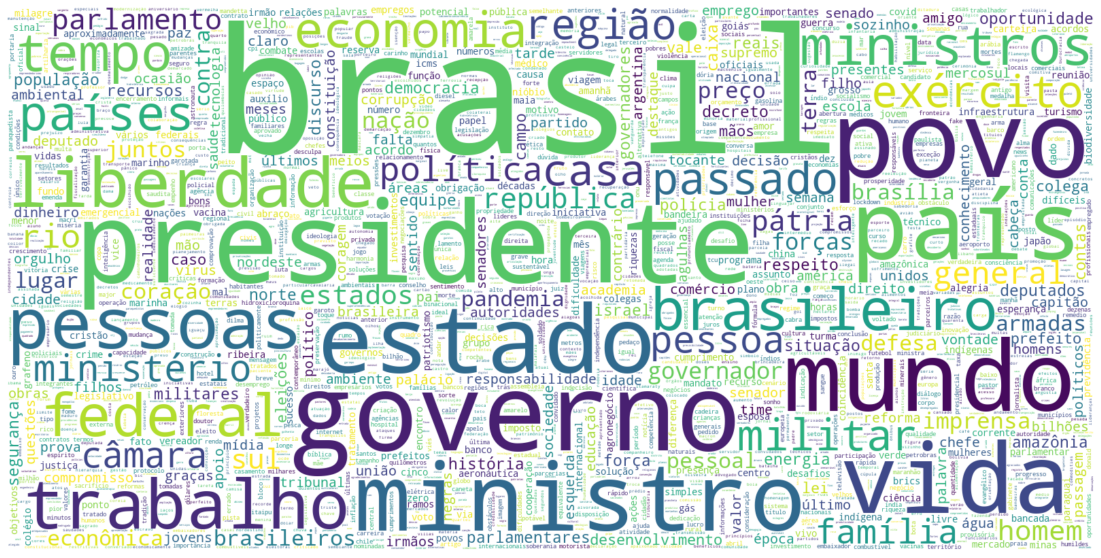

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.savefig("depois_Wc.png")
plt.axis('off')
plt.show()
from google.colab import files

files.download("depois_Wc.png")

count     456.000000
mean      195.894737
std       160.948309
min        13.000000
25%        90.000000
50%       152.500000
75%       239.000000
max      1400.000000
Name: Texto_Limpo, dtype: float64
count     456.000000
mean      195.894737
std       160.948309
min        13.000000
25%        90.000000
50%       152.500000
75%       239.000000
max      1400.000000
Name: Texto_Limpo, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

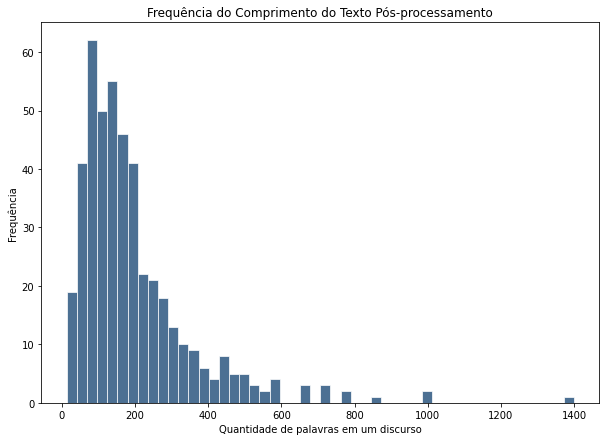

In [ ]:
lens = df.Texto_Limpo.str.split().apply(lambda x: len(x)) # Quantidade de palavras no texto
print(lens.describe()) 
print(lens.describe()) 
#lens.hist() # fazer um gráfico melhor!!!!!!!

fig = plt.figure(figsize =(10, 7))
plt.title('Frequência do Comprimento do Texto Pós-processamento')
plt.xlabel('Quantidade de palavras em um discurso')
plt.ylabel('Frequência')
plt.hist(lens, 50, color='#003366', alpha=0.7,edgecolor='white')
plt.savefig("depois_freq.png")
files.download("depois_freq.png")
plt.show()

### Embedding

In [ ]:
def sent(text):
  text = text.strip()
  text = text.lower() #colocar em minusculo
  lista = sent_tokenize(text) # separa por frase
  lista_def,lista_s1 = [],[]# criando uma nova lista
  ini,fim,cont = 0,len(lista)//10,1 # vai juntar as frases a cada 10 frases da lista do sent_tokenize
  while cont <= 10: #Falar que foi um teste. 
    if cont == 10:
      sentenca = ' '.join(lista[ini:len(lista)])
      s1 = ' '.join(lista[ini:len(lista)])
    else:
      sentenca = ' '.join(lista[ini:fim])
      s1 = ' '.join(lista[ini:fim])
    sentenca = re.sub(r"[^a-zA-ZáàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ]", " ", sentenca) # só palavras
    sentenca = word_tokenize(sentenca) #separa por palavras para 
    sentenca = [palavra for palavra in sentenca if palavra not in stopwords] #tira as stopwords
    sentenca = [token for token, pos in pos_tag(sentenca) if lambda pos: pos[:2] == 'NN' ] # em teoria eram pra ficar somente substantivos
    sentenca = [token for token  in sentenca if len(token) >= 3] # palavras maior ou igual a 3
    sentenca = ' '.join(sentenca) # Transforma em frase de novo
    if sentenca != '':
      lista_def.append(sentenca) #adiciona na lista_def se não for vazia
      lista_s1.append(s1)

    ini = fim
    fim = fim + len(lista)//10
    cont += 1
  return lista_def

#lista_def = df.apply(lambda x: sent(x['Texto']),axis=1)
df['sent_series'] = df.apply(lambda x: sent(x['Texto']),axis=1)

In [ ]:
df['sent_'] = df.apply(lambda x: sent(x['Texto']),axis=1)

In [ ]:
df.head()

,Ind,DataHora,Titulo,Texto,Texto_Limpo,sent_series,sent_
0,1,15/10/2021 14h42,"Discurso do Presidente da República, Jair Bols...",(...). Eu amo Israel.\nAgradeço a Deus pela mi...,amo israel agradeço deus vida missão hoje pres...,[israel vida presidente respeita constituição ...,[(...). eu amo israel. agradeço a deus pela mi...
1,2,13/10/2021 17h05,"Discurso do Presidente da República, Jair Bols...","Miracatu/SP, 13 de outubro de 2021\n\nBom dia ...",miracatu outubro bom dia todos primeiro obriga...,[vida nação vale ribeira região cresci academi...,"[miracatu/sp, 13 de outubro de 2021\n\nbom dia..."
2,3,09/10/2021 16h48,"Discurso do Presidente da República, Jair Bols...",É uma satisfação mais uma vez voltar a esse am...,satisfação vez voltar ambiente pesquisa desenv...,[ambiente pesquisa desenvolvimento tempo tempo...,[é uma satisfação mais uma vez voltar a esse a...
3,4,07/10/2021 22h14,"Discurso do Presidente da República, Jair Bols...",Boa tarde a todos a gente se pergunta como é q...,boa tarde todos gente pergunta vencemos ano pa...,[tarde pandemia carteiras assinadas pandemia c...,[boa tarde a todos a gente se pergunta como é ...
4,5,06/10/2021 19h51,"Discurso do Presidente da República, Jair Bols...","Boa tarde a todos, tô me sentindo 40 anos mais...",boa tarde todos sentindo anos jovem nesse mome...,[tarde jovem atleta imagem vale milhão palavra...,"[boa tarde a todos, tô me sentindo 40 anos mai..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ind          456 non-null    int64 
 1   DataHora     456 non-null    object
 2   Titulo       456 non-null    object
 3   Texto        456 non-null    object
 4   Texto_Limpo  456 non-null    object
 5   sent_series  456 non-null    object
 6   sent_        456 non-null    object
dtypes: int64(1), object(6)
memory usage: 25.1+ KB


In [ ]:
# essa parte transforma a coluna sent_series em um data frame. 
sent_series, ind,sent_ = [],[],[]
for i in range(0,df.shape[0]):
  sent_series_prov = df.loc[i,'sent_series']
  sent = df.loc[i,'sent_']
  ind_prov = [df.loc[i,'Ind']]*len(sent_series_prov)
  sent_series.extend(sent_series_prov)
  #sent_.extend(sent)
  ind.extend(ind_prov)
  

In [ ]:
sent_df = pd.DataFrame({'Ind':ind,'sent_series':sent_series})
sent_df.head()

,Ind,sent_series
0,1,israel vida presidente respeita constituição f...
1,1,seríssimo ministério acordo vontade vontade gr...
2,1,vírus desempregos mundo casa economia servidor...
3,1,pesquisei coragem aprontar confiei autonomia m...
4,1,governadores prefeitos constituição incisos ar...


In [ ]:
fname = get_tmpfile(f"/content/drive/My Drive/TCC/w2v.vectors.kv")  #modelo treinado por: xxxx. Disponível no site: xxxx
w2v = KeyedVectors.load(fname, mmap = 'r')
w2v.similarity('pandemia','covid') # Testando a similaridade de palavras 
print(f"Tokens: {len(w2v.wv.vocab.keys())}")  #Quantidade de palavras no modelo

Tokens: 981032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [ ]:
def embed(doc_tokens):
  a =[]
  embeddings = []
  doc_tokens = word_tokenize(doc_tokens)
  if len(doc_tokens) < 1: # se o tamanho do token for menor que 1
    return np.zeros(300)
  else: 
    for tok in doc_tokens: 
      #print(tok)
      if tok in w2v.wv.vocab: #se tiver no vocabulario do modelo, coleta o word_embedding dele
        embeddings.append(w2v.wv.word_vec(tok))
        
      else: # se não tiver adiciona uma matriz aleatória de distribuição uniforme [0,1] do tamanho do modelo
        embeddings.append(np.random.rand(300)) 
    return np.mean(embeddings,axis = 0 ) # retorna a média dos embeddings da lista 

In [ ]:
emb = sent_df['sent_series'].apply((lambda x: embed(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
emb1 = torch.tensor(emb).numpy() # word embeddings das frases dos discursos
emb1.shape 

(4340, 300)

## Modelagem
- Tratamento da Query
- Expansão da busca do W2V na query
- Embedding na query
- Similaridade Semântica entre docs e query \
- Retorna os similares. 
- Análise entre similares (?)

#### Tratamento da query (Expansão de busca e embeddings)

In [ ]:
def expansao_busca(query):
  query = clean_text(query) # mesma limpeza que foi realizada nos documentos
  query = word_tokenize(query) # separa por palavras 
  palavras_similares = [] # lista de palavras similares
  query_x = [] # lista de palavras definitavas
  for i in query:
    palavras_similares = []
    similares = w2v.most_similar(positive = i,topn=10) # 10 palavras mais similares
    for j in range(0,len(similares)): #Adiciona as palavras similares a lista provisória: palavras_similares
      palavras_similares.append(similares[j][0])
    query_x.extend(palavras_similares) #Adiciona as palavras similares a lista definitiva de palavras similares: query_x
  query.extend(query_x) # Ao final adiciona a lista definitiva de palavras similares na lista de query
  return query

def busca(query):
  lista_query = expansao_busca(query) # Realiza a expansão da busca na lista de palavras fornecida pelo usuário
  lista_query = [palavra for palavra in lista_query if palavra not in stopwords] #tira as stopwords
  lista_query = [token for token, pos in pos_tag(lista_query) if lambda pos: pos[:2] == 'NN'] # deixa somente pronomes
  lista_query = ' '.join(lista_query)
  query = pd.DataFrame({"sent_query": pd.Series(lista_query)}) #Trasnforma em um dataframe
  sent_query = query['sent_query'].apply((lambda x: embed(x))) #Aplica a função do word embedding 
  embeddings_q = torch.tensor(sent_query).numpy() 
  return embeddings_q


In [ ]:
w2v.most_similar('moradia',topn=10)

[('moradias', 0.786594808101654),
 ('habitação', 0.748525083065033),
 ('habitações', 0.7178720831871033),
 ('residencial', 0.6954886317253113),
 ('habitacionais', 0.6889368891716003),
 ('condomínio', 0.6785115599632263),
 ('inquilinos', 0.6672083735466003),
 ('rés', 0.666111946105957),
 ('vivendas', 0.6642895340919495),
 ('alojamentos', 0.6642045974731445)]

### Similaridade Semântica (Modelo Vetorial)

In [ ]:
def cosine_similarity_func(embeddings,embeddings_query):
    # x.y
    dot_product = np.sum(np.multiply(np.array(embeddings),np.array(embeddings_query)),axis=1)
    
    #||x||.||y||
    prod_sqrt_magnitude = np.multiply(np.sum(np.array(embeddings)**2,axis=1)**0.5, np.sum(np.array(embeddings_query)**2,axis=1)**0.5)
    
    #x.y/(||x||.||y||)
    cosine_similarity  = dot_product/prod_sqrt_magnitude
    return cosine_similarity

In [ ]:
def recommended_text(embeddings_query,embeddings,sent,ind,threshold_min=.95):

    recommend_text = []
        
    cosine_similarity = cosine_similarity_func(embeddings,embeddings_query) 
    
    # Padronizar entre 0 e 1 a similaridade de cosseno 
    standardize_cosine_simi  = (cosine_similarity-min(cosine_similarity))/(max(cosine_similarity)-min(cosine_similarity))
    
    #Classifica conforme a padronização realizada acima
    sent_prob = pd.DataFrame({'Similaridade':standardize_cosine_simi,'Trecho':sent,'Ind':ind})
    sent_prob.sort_values(by=['Similaridade'],ascending=False,inplace=True)
    
    sent_prob  =sent_prob[sent_prob.Similaridade > threshold_min] 
    sent_prob = sent_prob.merge(df, left_on='Ind', right_on='Ind')
    return sent_prob

### Teste

In [ ]:
query = 'covid é uma doença causada por vírus'
embeddings_q = busca(query)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
result = recommended_text(embeddings_q,emb1,sent_series,ind,threshold_min = .9)

## 0.998 é um número muito grande, testar com 0.9993 ou 0.9995 

result1 = result.sort_values('Similaridade', ascending=False).reset_index()
#result1 = result1.drop_duplicates(subset='Ind', keep='first').reset_index()
result1.head()

,index,Similaridade,Trecho,Ind,DataHora,Titulo,Texto,Texto_Limpo,sent_series,sent_
0,0,1.000000,recomendo covid médico tratamento precoce hidr...,59,18/06/2021 21h07,"Discurso do Presidente da República, Jair Bols...","Novo Repartimento/PA, 18 de junho de 2021\n \n...",novo repartimento junho preço andar brasil ser...,[repartimento preço andar brasil povo brasilei...,"[novo repartimento/pa, 18 de junho de 2021\n \..."
1,1,0.973854,resposta observações pessoas medicamento carga...,159,19/10/2020 21h24,"Discurso do Presidente da República, Jair Bols...","Boa tarde, antes de entrar no assunto, eu quer...",boa tarde antes entrar assunto queria falar so...,[tarde assunto notícia fake news verdadeira co...,"[boa tarde, antes de entrar no assunto, eu que..."
2,2,0.965249,brasil países mundo capacidade vacinas deputad...,102,10/03/2021 18h07,"Discurso do Presidente da República, Jair Bols...","Senhor presidente Rodrigo Pacheco, satisfação ...",senhor presidente rodrigo pacheco satisfação a...,[presidente velho amigo parlamento câmara depu...,"[senhor presidente rodrigo pacheco, satisfação..."
3,4,0.958245,vida preço desemprego depressão doença morte e...,202,13/08/2020 13h16,"Discurso do Presidente da República, Jair Bols...","Belém/PA, 13 de agosto de 2020\nBom dia a todo...",belém agosto bom dia todos satisfação grande e...,"[estado velhos coração cinco pai, pai mãe famí...","[belém/pa, 13 de agosto de 2020\nbom dia a tod..."
4,5,0.956971,pessoa deficiência pessoas pobres quantidade v...,133,10/12/2020 14h11,"Discurso do Presidente da República, Jair Bols...","​Barra do Ribeiro/RS, 10 de dezembro de 2020\n...",barra ribeiro dezembro bom dia satisfação gran...,[barra dezembro estado rio sul paulista adotad...,"[​barra do ribeiro/rs, 10 de dezembro de 2020\..."


In [ ]:
result1.loc[19,'sent_']

['anápolis/go, 09 de junho de 2021\n\xa0\nconfesso que esperava que não ia fazer uso da palavra. não levo jeito para ser orador. jamais poderia ocupar a vaga aí do nosso prezado pastor thiago. mas cada um tem o seu propósito aqui na terra. e é muito bom estar entre aqueles que tem deus no coração. então uma saudação a todos vocês, em nome de cristo. fui convidado pelo victor hugo, para vir para goiás. acabei de almoçar com amado batista, só quem é mais velho sabe quem ele é, com que ele mexe, mas é nossa vida. eu jamais esperava estar nessa função um dia, jamais. aqui temos também o onyx lorenzoni, deputado federal, o daniel também, deputado federal por santa catarina, um garoto novo, primeiro mandato. e eu quero dar um testemunho aqui. eu comecei meu 8º, meu 7° mandato em brasília. e uma senhora foi reeleita e nós estamos acompanhando 12 anos daquele partido com pessoas que pensam de forma muito semelhante daquele partido. família estava em terceiro plano, compromisso com a ética, com

### O que pode ser feito
- Uma análise exploratória de quantos discursos o documento retornou, uma análise exploratória dos trechos retornados (com algum tipo de visualização)
- Avaliação de Coerência entre tópico e textos (é possível?)
- Alguma forma de análise exploratória dos textos coletados